In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time 
import math 
import detector7 as de
import ROOT 
import matplotlib as mpl 

Welcome to JupyROOT 6.26/06


# How to use this Jupyter notebook 

Code in this Jupyter notebook merges pixel data and strip data from the old MiniPAN runs where trigger synchronization wasn't available. It is intended to use in a way that you run all the cells one after another to load the data, find the trigger shift between pixel and quad data, merge them together applying the trigger shift, visually check if the merging was correct and in the end save a `ROOT` file with merged data. 

Occasins that mqy require you to change some inputs to the code (i.e. path to the file, trigger shift number, ...) are highlighted in the code with a comment line starting with `# -> USER INPUT: `. 

# Load data from pixel and strip detectors

The package `detector7` provides function `LoadRootCoinFile()` that can read both pixel `ROOT` files and strip `ROOT` files. 

In [2]:
# Load data from pixel detectors. Pixel data are stored in a ROOT file created by Benedikt. 
# -> USER INPUT: path to the quad file merged by Benedikt. Also specify detector names and detector types. 
path = r"Quad_Data/20220805_1921_run9_rep1.root"    # Path to the ROOT file with clusters data. 
DetNames = ["quad1", "quad2"]                       # Detector names (must be unique)
DetTypes = ["quad", "quad"]                         # Detector types ('quad' or 'strip')

Quads = de.LoadRootCoinFile(path, DetNames, DetTypes, creator="Benedikt")

The tree from 2 detectors has 48318 entries.
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100 % entries, 2.45 s   


In [3]:
# Check one of the entries in pixels data list if it makes sense. 
print(Quads.Data[1000])

{'quad1': [[103.0, 163.0, 35129278776.5625, 102.87797546386719]], 'quad2': [[135.0, 137.0, 35129278464.0625, 93.82061767578125]], 'trigNo': 1000, 'fCounter': [], 'trigtime': 35.12927940833}


In [4]:
# Load data from strip detectors. Strips data are stored in a ROOT file merged by Daniil. 
# -> USER INPUT: path to the strip synced file. Also specify detector names and detector types. 
path = r"Strip_Data/synced_clusters_05082022_1905.root"                  # Path to the ROOT file. 
DetNames = ["strip1", "strip2", "strip3", "strip4", "strip5", "strip6"]  # Detector names (must be unique)
DetTypes = ["strip", "strip", "strip", "strip", "strip", "strip"]        # Detector types

Strips = de.LoadRootCoinFile(path, DetNames, DetTypes, creator="Daniil - new")

# Some of the strip detectors are 180° rotated in MiniPAN -> we need to reverse cog-coordinate of odd-number detectors. 
to_reverse = ["strip1", "strip3", "strip5"]
for i, event in enumerate(Strips.Data): 
    for detector in to_reverse: 
        for k, item in enumerate(event[detector]): 
            Strips.Data[i][detector][k][0] = 2048 - Strips.Data[i][detector][k][0] - 1

The tree from 6 detectors has 48317 entries.
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100 % entries, 6.23 s   


In [5]:
# Check one of the entries in strips data list if it makes sense. 
print(Strips.Data[1000])

{'strip1': [[732.8480224609375, 22.74039077758789, 2, 9.969794273376465]], 'strip2': [[727.0986328125, 25.55029296875, 2, 11.262482643127441]], 'strip3': [[755.00244140625, 28.803327560424805, 3, 10.116215705871582]], 'strip4': [[748.000244140625, 22.910688400268555, 1, 13.836002349853516]], 'strip5': [[778.11279296875, 29.103302001953125, 2, 12.849550247192383]], 'strip6': [[773.153076171875, 34.16195297241211, 4, 10.301375389099121]], 'trigNo': 1002, 'fCounter': [91180464427, 91180464427, 91165436979, 91165436979, 91180233554, 91180233554], 'trigtime': None}


# Find the trigger shift between pixel and strip detectors

In order to merge strips and pixels data, we have to find the relative trigger number shift between the two data sets (i.e. trigger number 1000 in pixel data may not correspond to trigger number 1000 in strips data). We expect the trigger shift to be close to 0, therefore we limit our search by trial and error only to values close to 0. 

In [18]:
# Get trigger numbers from strip detectors. 
Trigs = Strips.CommonEntries 

# Get trigger numbers from pixel detectors. 
Triggers = Quads.CommonEntries 

print(f"""Number of strip detector entries: {len(Trigs)}
Number of pixel detector entries: {len(Triggers)}
Their difference: {len(Triggers) - len(Trigs)}""")

Number of strip detector entries: 48317
Number of pixel detector entries: 48318
Their difference: 1


In [19]:
start = time.time()

# Find the trigger shift by trial and error by trying various shifts around 0. 
# -> USER INPUT: if you don not find the trigger shift in the range from -10 to 10, 
#    you will have to extend the search region. The same applies also if the shift you 
#    find is not valid for the whole file, i.e. if the shift changes in the middle of the file. 
shifts = np.linspace(-10,10,21).astype(int) # Explore trigger shifts only close to 0. 
m = math.ceil(len(shifts) / 100)
multiple = 0 

STDs = np.zeros(len(shifts)) 

for i, shift in enumerate(shifts): 
    shift = int(shift)
    AllCoin = de.AllCoincidences() 
    AllCoin.calculatedata(Strips, Quads, shift=shift, progress=False) # Introduce relative shift between the data sets. 
    TrigNumbers = de.ExtractData(AllCoin, 'trigNo')
    fC = de.ExtractData(AllCoin, 'fCounter', fCounterIndex=0)
    ll = len(fC)-1
    fC2 = np.zeros(ll) 
    for j in range(ll): 
        fC2[j] = fC[j+1]-fC[j]
    Tt = de.ExtractData(AllCoin, 'trigtime') 
    ll = len(Tt)-1
    Tt2 = np.zeros(ll) 
    for j in range(ll): 
        Tt2[j] = Tt[j+1]-Tt[j]
    ll = min(len(Tt2), len(fC2))
    Data = []
    for j in range(ll): 
        ratio = fC2[j] / Tt2[j]
        if ratio > 0: # Avoid the trigger when frame counter overflowed (negative ratio). 
            Data.append(np.log(ratio))
    STDs[i] = np.std(Data) # Standard deviation of time differences. 
    
    if i>=multiple*m: 
        multiple += 1 
        print('|'*(multiple) + ' {} %, {} s'.format(multiple, round(time.time() - start, 2)), end='\r')
        
print('|'*(100) + ' 100 %, {} s'.format(round(time.time() - start, 2)))

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100 %, 7.48 s


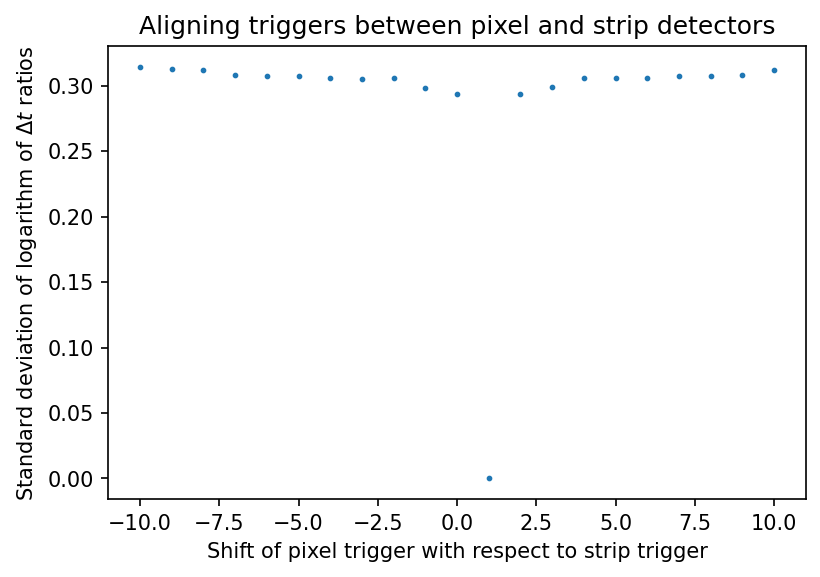

In [20]:
plt.figure(dpi=150) 
plt.xlabel(r"Shift of pixel trigger with respect to strip trigger")
plt.ylabel(r"Standard deviation of logarithm of $\Delta t$ ratios")
plt.title(r"Aligning triggers between pixel and strip detectors")

plt.scatter(shifts, STDs, s=3)

We see that the trigger shift is +1 when the standard deviation of logarithm of ratio between frame counter difference and time difference is the lowest -- when the triggers are aligned, frame counter difference is directly protportional to the time difference and their ratio is constant. 

Now let's check if this trigger shift is valid for the whole data set. 

In [21]:
# Here write the trigger shift that you found in the graph above. 
# -> USER INPUT: Here write the shift number that you visually identified in the plot above. 
shift = 1

AllCoin = de.AllCoincidences() 
AllCoin.calculatedata(Strips, Quads, shift=shift, progress=False)
TrigNumbers = de.ExtractData(AllCoin, 'trigNo')
fC = de.ExtractData(AllCoin, 'fCounter', fCounterIndex=0)
ll = len(fC)-1 
fC2 = np.zeros(ll) 
for j in range(ll): 
    fC2[j] = fC[j+1]-fC[j]
Tt = de.ExtractData(AllCoin, 'trigtime') 
ll = len(Tt)-1 
Tt2 = np.zeros(ll) 
for j in range(ll): 
    Tt2[j] = Tt[j+1]-Tt[j]
ll = min(len(Tt2), len(fC2))
Data = []
for j in range(ll): 
    ratio = fC2[j] / Tt2[j]
    if ratio > 0: # Avoid the trigger when frame counter overflowed (negative ratio). 
        Data.append(np.log(ratio))
        
print(np.mean(Data), np.std(Data))

17.727540879679186 4.80301955292932e-06


We see that all ratios between frame counter difference and time difference are around 17.73 with only a little standard deviation. This means that our trigger shift is valid for the whole data set. Let's just confirm it with a plot. 

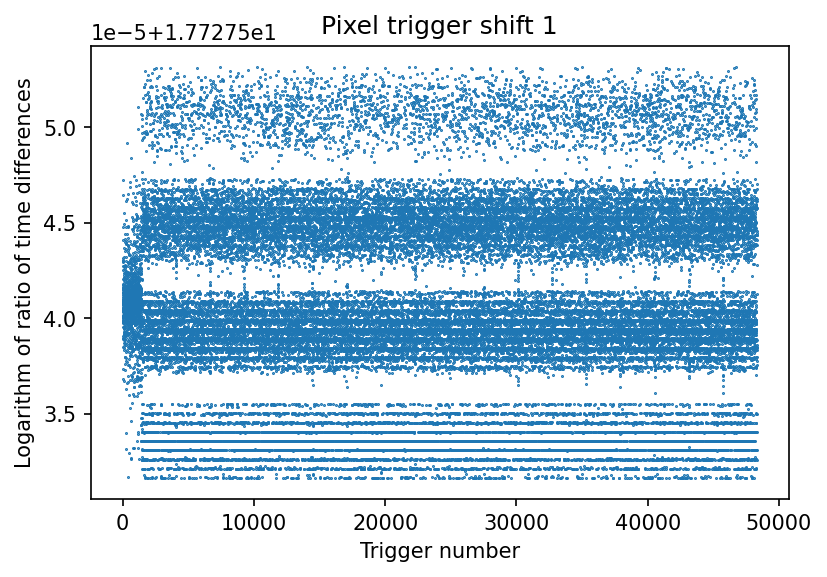

In [22]:
TrigNumbers2 = np.array(TrigNumbers) 
Data2 = np.array(Data) 

ll = min(len(TrigNumbers2), len(Data2))

plt.figure(dpi=150)
plt.xlabel("Trigger number")
plt.ylabel("Logarithm of ratio of time differences") 
plt.title(r"Pixel trigger shift {}".format(shift))

plt.scatter(TrigNumbers2[:ll], Data2[:ll], s=0.2)

# Find coincidences between strip detectors and pixel detectors 

Now, when we know the trigger shift, we can finally find the coincident clusters between strip and pixel detectors! 

In [23]:
# Merge the strip and pixel data
AllCoin = de.AllCoincidences() 
AllCoin.calculatedata(Strips, Quads, shift=shift, change_shift=[np.inf])
print('There were {} coincident events.'.format(len(AllCoin.Data)))

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100 % triggers, 0.3 s   
There were 48317 coincident events.


# Visual check if the clusters are indeed aligned 

We will plot the 2D track of the particle through the detectors. 

In [24]:
print(AllCoin.Names) 

['strip1', 'strip2', 'strip3', 'strip4', 'strip5', 'strip6', 'quad1', 'quad2']


In [25]:
# This piece of code will print numbers of events that are likely nuclear reactions in the first quad 
# layer with a subsequent particle shower in all other detectors. With these events, you can easily check 
# if the clusters are aligned. 
# If you want to display one of the clusters, use the first number from the lines that will be printed in output. 
Names = ['quad1', 'strip1', 'strip2', 'strip3', 'strip4', 'strip5', 'strip6', 'quad2']
for i, coin in enumerate(AllCoin.Data): 
    trigNo = coin["trigNo"] 
    to_print = str(i)+' '+str(trigNo) 
    Lengths = []
    for name in Names: 
        to_print += ' '+str(len(coin[name]))
        Lengths.append(len(coin[name]))
    
    # Now let's find some events where there was probably nucleus disintegrations in quad 1 
    # (i.e. high energy deposition in quad1 and particle shower in other detectors).
    is_good=True
    if Lengths[0]!=1: # There must have been only one itńteraction in the first quad (nuclear reaction)
        is_good=False
    else:
        E = coin['quad1'][0][3]
        if E < 4000: # If energy was too low ... 
            is_good=False
    for j in range(1,8): 
        if Lengths[j]<=2: 
            is_good=False 
    if is_good: 
        print(to_print + '   ' + str(E)) 

9642 9644 1 11 11 12 11 9 9 4   9149.294921875
10966 10968 1 19 23 19 19 16 16 10   9463.2783203125
11690 11692 1 19 18 18 15 14 13 8   11086.833984375
19612 19614 1 14 15 12 16 7 8 7   14173.5703125
28185 28187 1 18 16 14 15 12 10 10   6999.603515625
34263 34265 1 11 12 10 9 7 7 4   4168.9873046875
35796 35798 1 16 18 18 16 14 16 8   6918.6533203125
39100 39102 1 21 22 16 13 13 10 4   20981.0234375
40427 40429 1 18 18 19 19 7 7 4   4880.453125


In [30]:
# -> USER INPUT: Write number of the event that you want to display in a graph. 
#    If you want to display one of the nuclear reaction candidates, write the first 
#    number from one of the lines that you printed in the previous cell. 
g = 9642

if g<0 or g>=len(AllCoin.Data): 
    raise ValueError(r"Input g must be a positive integer between 0 (inclusive) and {} (exclusive).".format(len(AllCoin.Data))) 
    
coin = AllCoin.Data[g] 
trig_no = coin["trigNo"]

C1 = np.zeros([len(coin['quad1']), 2])
S1 = np.zeros([len(coin['strip1']), 2])
S2 = np.zeros([len(coin['strip2']), 2])
S3 = np.zeros([len(coin['strip3']), 2])
S4 = np.zeros([len(coin['strip4']), 2])
S5 = np.zeros([len(coin['strip5']), 2])
S6 = np.zeros([len(coin['strip6']), 2])
C2 = np.zeros([len(coin['quad2']), 2]) 

for i, CluData in enumerate(coin['quad1']): 
    C1[i,0] = (-CluData[1])*55/1000.0
    C1[i,1] = CluData[3] 
    
for i, StrData in enumerate(coin['strip1']): 
    S1[i,0] = (StrData[0]-1024)*25/1000.0
    S1[i,1] = StrData[1]

for i, StrData in enumerate(coin['strip2']): 
    S2[i,0] = (StrData[0]-1024)*25/1000.0 
    S2[i,1] = StrData[1]
    
for i, StrData in enumerate(coin['strip3']): 
    S3[i,0] = (StrData[0]-1024)*25/1000.0 
    S3[i,1] = StrData[1]
    
for i, StrData in enumerate(coin['strip4']): 
    S4[i,0] = (StrData[0]-1024)*25/1000.0 
    S4[i,1] = StrData[1]
    
for i, StrData in enumerate(coin['strip5']): 
    S5[i,0] = (StrData[0]-1024)*25/1000.0 
    S5[i,1] = StrData[1]
    
for i, StrData in enumerate(coin['strip6']): 
    S6[i,0] = (StrData[0]-1024)*25/1000.0 
    S6[i,1] = StrData[1]
    
for i, CluData in enumerate(coin['quad2']): 
    C2[i,0] = (-CluData[1])*55/1000.0 
    C2[i,1] = CluData[3] 

Text(0, 0.5, 'Strip detector cluster ADC')

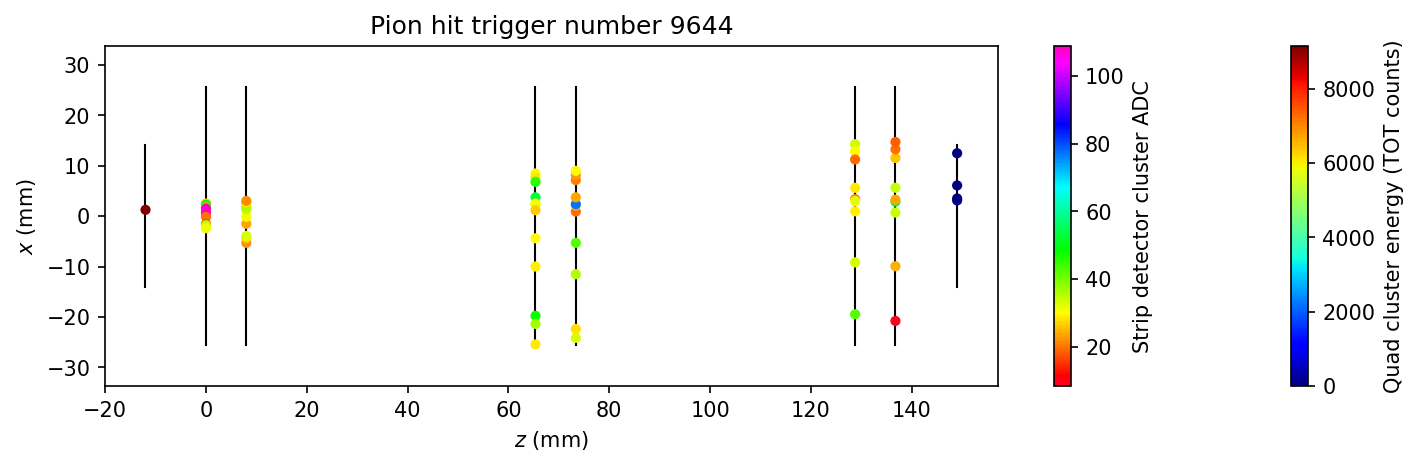

In [31]:
fig = plt.figure(dpi=150, figsize=(12,3)) 
fig.patch.set_facecolor('white') # White background

#plt.axis('off')
ax = plt.axes()
ax.axis('equal')
plt.xlabel(r"$z$ (mm)")
plt.ylabel(r"$x$ (mm)")
plt.title(r"Pion hit trigger number {}".format(trig_no))

# Detectors 
col = 'k'
plt.plot([-12,-12], [-14.08,14.08], linewidth=1, color=col, zorder=1)
plt.plot([0,0], [-25.6,25.6], linewidth=1, color=col, zorder=1)
plt.plot([8,8], [-25.6,25.6], linewidth=1, color=col, zorder=1)
plt.plot([65.36,65.36], [-25.6,25.6], linewidth=1, color=col, zorder=1)
plt.plot([73.36,73.36], [-25.6,25.6], linewidth=1, color=col, zorder=1)
plt.plot([128.76,128.76], [-25.6,25.6], linewidth=1, color=col, zorder=1)
plt.plot([136.76,136.76], [-25.6,25.6], linewidth=1, color=col, zorder=1)
plt.plot([149,149], [-14.08,14.08], linewidth=1, color=col, zorder=1) 

Cx = []
C = np.zeros([len(C1)+len(C2), 2]) 
counter = 0 
for row in C1: 
    C[counter,:] = row 
    counter += 1
    Cx.append(-12)
for row in C2: 
    C[counter,:] = row 
    counter += 1
    Cx.append(149) 
    
Sx = []
S = np.zeros([len(S1)+len(S2)+len(S3)+len(S4)+len(S5)+len(S6), 2])
counter = 0
for row in S1: 
    S[counter,:] = row 
    counter += 1
    Sx.append(0)
for row in S2: 
    S[counter,:] = row 
    counter += 1
    Sx.append(8) 
for row in S3: 
    S[counter,:] = row 
    counter += 1
    Sx.append(65.36)
for row in S4: 
    S[counter,:] = row 
    counter += 1
    Sx.append(73.36)
for row in S5: 
    S[counter,:] = row 
    counter += 1
    Sx.append(128.76)
for row in S6: 
    S[counter,:] = row 
    counter += 1
    Sx.append(136.76)

imagespix = []
imagesstr = []
imagespix.append(plt.scatter(Cx, C[:,0], c=C[:,1], s=15, zorder=2, cmap="jet"))
imagesstr.append(plt.scatter(Sx, S[:,0], c=S[:,1], s=15, zorder=2, cmap="gist_rainbow")) 

cbar1 = fig.colorbar(imagespix[0])
cbar1.ax.set_ylabel(r"Quad cluster energy (TOT counts)")
cbar2 = fig.colorbar(imagesstr[0])
cbar2.ax.set_ylabel(r"Strip detector cluster ADC")

# Save the ROOT file

In [29]:
# -> USER INPUT: Write path to the ROOT file where you want to save the merged data. 
path = r"Merged_Data/20230805_1905_merged.root" # Name of the file that you want to save. 
de.SaveRootCoinFile(path, AllCoin)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100 %, 7.64 s   
